In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    outdir: str = "yolov5_results/results01"
    datadir: str = "../../data/yolov5_data"
    device: str = "cuda:1"
    device_id: int = 1
    num_workers: int = 8
        
    # Training config
    batch_size: int = 4

    # Data config
    imgconf_file: str = '../../data/VinBigData/test.csv'
    meta_file: str = '../../data/VinBigData/train_meta.csv'
    test_meta_file: str = '../../data/VinBigData/test_meta.csv'
    imgdir_name: str = "../../data/VinBigData/png1024"
    img_size: int = 1024
    seed: int = 111
    n_splits: int = 5
       
    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [3]:
config = Config()
base_dir = Path().resolve()

In [4]:
def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

In [5]:
classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
#     "No Finding"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from pathlib import Path
import json
import re
import logging
import gc
import random
import warnings
from tqdm.notebook import tqdm
from PIL import Image
import os
from glob import glob
from joblib import Parallel, delayed
import shutil as sh
from itertools import product
from collections import OrderedDict
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from ensemble_boxes import nms, weighted_boxes_fusion
import torchvision.transforms as transforms
import albumentations as al
from albumentations import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2, ToTensor
from albumentations.core.transforms_interface import DualTransform, ImageOnlyTransform

import cv2
# import pydicom
from IPython.display import display, Image
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold
import torch
from torch.nn import functional as f
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, sampler
import timm
# from efficientnet_pytorch import EfficientNet

pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s +++ %(message)s',
                    datefmt='%d-%m-%y %H:%M:%S', level=logging.INFO)
logger = logging.getLogger()

device = torch.device(config.device if torch.cuda.is_available() else 'cpu')
logger.info(device)

30-03-21 12:09:38 +++ cuda:1


In [7]:
size_df = pd.read_csv(str(base_dir / config.test_meta_file))
size_df.columns = ['image_id', 'h', 'w']

In [19]:
for fold in tqdm(range(config.n_splits)):
    outdir = base_dir / config.outdir / f'fold-{fold + 1}'
    exp_dir = outdir / 'runs' / 'train'
    exp_last = sorted(os.listdir(str(exp_dir)))[-1]
    weight_path = str(exp_dir / exp_last / 'weights' / 'best.pt')

    test_data_path = str(base_dir / config.imgdir_name / 'test')
    project_dir = str(outdir / 'runs' / 'inference')
    
    !python ./yolov5/detect.py --weights $weight_path --img-size $config.img_size --conf-thres 0.005 --source $test_data_path --iou-thres 0.45 --save-txt --save-conf --project $project_dir --device $config.device_id

  0%|          | 0/5 [00:00<?, ?it/s]

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.005, device='1', exist_ok=False, img_size=1024, iou_thres=0.45, name='exp', project='/home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/yolov5_results/results01/fold-1/runs/inference', save_conf=True, save_txt=True, source='/home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/../../data/VinBigData/png1024/test', update=False, view_img=False, weights=['/home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/yolov5_results/results01/fold-1/runs/train/exp3/weights/best.pt'])
YOLOv5  torch 1.7.1+cu101 CUDA:1 (Tesla V100-PCIE-32GB, 32510.5MB)

Fusing layers... 
Model Summary: 476 layers, 87286171 parameters, 0 gradients, 217.4 GFLOPS
image 1/3000 /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/../../data/VinBigData/png1024/test/002a34c58c5b758217ed1f584ccbcfe9.png: 1024x1024 1 Aortic enlargement, 1 Cardiomegaly, 3 ILDs, 1 Infiltration, 7 Ple

In [8]:
def to_objects(detect_result, conf_thr):
    objs = np.array(list(map(float, re.split(r'[\n ]', detect_result)[:-1]))).reshape(-1, 6)

    labels = objs[:, 0]
    x_centers = objs[:, 1].copy()
    y_centers = objs[:, 2].copy()
    widths = objs[:, 3].copy()
    heights = objs[:, 4].copy()
    scores = objs[:, 5]

    x_mins = x_centers - 0.5 * widths
    x_maxs = x_centers + 0.5 * widths
    y_mins = y_centers - 0.5 * heights
    y_maxs = y_centers + 0.5 * heights
    boxes = np.vstack([x_mins, y_mins, x_maxs, y_maxs]).T

    mask = (scores > conf_thr)
    boxes = boxes[mask, :]
    labels = labels[mask]
    scores = scores[mask]
    
    return boxes, labels, scores

In [9]:
iou_thresh = 0.4
iou_thresh2 = 0.1
iou_thresh11 = 0.0001
score_last = 0.0
score_last2 = 0.95
score_9 = 0.1
score_11 = 0.015
conf_thr = 0.0

In [10]:
test = pd.read_csv(str(base_dir / config.test_meta_file))

In [11]:
# make submission.csv
for fold in range(config.n_splits):
    outdir = base_dir / config.outdir / f'fold-{fold + 1}' 
    pred_dir = outdir / 'runs' / 'inference' / 'exp' / 'labels'
    files = sorted(os.listdir(pred_dir))
    files = [f for f in files if '.txt' in f]

    records = {'image_id': list(), 'PredictionString': list()}

    for file in tqdm(files):
        image_id = file.replace('.txt', '')
        _, height, width = test[test['image_id'] == image_id].values[0]
        
        filepath = str(pred_dir / file)
        with open(filepath, 'r+') as f:
            detect_result = f.read()
        boxes, labels, scores = to_objects(detect_result, score_last)

        boxes_, labels_, scores_ = list(), list(), list()
        for cls_id in range(len(classes_nms)):
            mask = (labels == cls_id)
            if mask.sum() == 0:
                continue
            elif mask.sum() == 1:
                p_boxes, p_scores, p_labels = boxes[mask, :], scores[mask], labels[mask]
            else:
                if cls_id == 2:
                    p_boxes, p_scores, p_labels = nms([boxes[mask, :]], [scores[mask]], [labels[mask]], weights=None, iou_thr=iou_thresh2)
                elif cls_id == 11:
                    p_boxes, p_scores, p_labels = nms([boxes[mask, :]], [scores[mask]], [labels[mask]], weights=None, iou_thr=iou_thresh11)
                else:
                    p_boxes, p_scores, p_labels = nms([boxes[mask, :]], [scores[mask]], [labels[mask]], weights=None, iou_thr=iou_thresh)
            
            if cls_id == 9:
                mask = (p_scores > score_9)
            elif cls_id == 11:
                mask = (p_scores > score_11)
            else:
                mask = (p_scores > score_last)

            p_boxes[:, [0, 2]] *= width
            p_boxes[:, [1, 3]] *= height

            boxes_ += p_boxes[mask, :].tolist()
            labels_ += p_labels[mask].tolist()
            scores_ += p_scores[mask].tolist()

        pred_str = list()
        for label, score, box in zip(labels_, scores_, boxes_):
            pred_str += [str(int(label))] + [str(np.round(score, 3))] + np.array(box).astype(int).astype(str).tolist()

        records['image_id'] += [image_id]
        records['PredictionString'] += [' '.join(pred_str)]

    pred_df = pd.DataFrame(records)
    pred_df.to_csv(str(outdir / 'submission.csv'))

  0%|          | 0/2993 [00:00<?, ?it/s]

Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 4 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. F

  0%|          | 0/2991 [00:00<?, ?it/s]

Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 3 boxes coordinates > 1. Check that your boxes was normalized at

  0%|          | 0/2996 [00:00<?, ?it/s]

Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. 

  0%|          | 0/2994 [00:00<?, ?it/s]

Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that y

  0%|          | 0/2998 [00:00<?, ?it/s]

Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixe

In [12]:
NORMAL = '14 1 0 0 1 1'

sample_submission = pd.read_csv(str(base_dir / 'sample_submission.csv'))
sample_submission = sample_submission.rename(columns={'PredictionString': 'PredicdtionString_'})
submission_det = pd.read_csv(str(base_dir / 'yolov5_results' / 'results01' / 'fold-1' / 'submission.csv'), index_col=0)
submission = pd.merge(sample_submission, submission_det)
submission.loc[submission[submission['PredictionString'].isnull()].index, 'PredictionString'] = NORMAL
submission

image_id PredicdtionString_  \
0     002a34c58c5b758217ed1f584ccbcfe9       14 1 0 0 1 1   
1     004f33259ee4aef671c2b95d54e4be68       14 1 0 0 1 1   
2     008bdde2af2462e86fd373a445d0f4cd       14 1 0 0 1 1   
3     009bc039326338823ca3aa84381f17f1       14 1 0 0 1 1   
4     00a2145de1886cb9eb88869c85d74080       14 1 0 0 1 1   
...                                ...                ...   
2988  ff91fb82429a27521bbec8569b041f02       14 1 0 0 1 1   
2989  ff9fcc4087ed5e941209aa3fa948e364       14 1 0 0 1 1   
2990  ffaa288c8abca300974f043b57d81521       14 1 0 0 1 1   
2991  ffc441e0c8b7153844047483a577e7c3       14 1 0 0 1 1   
2992  ffccf1709d0081d122a1d1f9edbefdf1       14 1 0 0 1 1   

                                       PredictionString  
0     0 0.207 1167 635 1433 905 3 0.296 815 1223 188...  
1     0 0.817 1263 585 1531 893 3 0.008 1268 585 152...  
2     0 0.786 1440 824 1736 1175 2 0.008 1440 824 17...  
3     0 0.706 996 479 1211 735 3 0.703 648 1063 1563...  
4     0 0.765 1118 710 1351 942 2 0.011 1301 771 134...  
...                                                 ...  
2988  0 0.809 1623 629 1884 917 0 0.007 857 1344 110...  
2989  0 0.815 1156 697 1424 1046 0 0.027 841 683 143...  
2990  1 0.031 1509 268 1992 571 1 0.007 1847 1536 23...  
2991  0 0.149 994 629 1232 918 3 0.065 751 1295 1503...  
2992  0 0.727 1386 883 1732 1268 0 0.008 400 1312 70...  

[2993 rows x 3 columns]

In [13]:
submission_2cls = pd.read_csv(str(base_dir / '2-cls test pred.csv'))
submission_2cls.head()

image_id    target
0  002a34c58c5b758217ed1f584ccbcfe9  0.013326
1  004f33259ee4aef671c2b95d54e4be68  0.037235
2  008bdde2af2462e86fd373a445d0f4cd  0.939700
3  009bc039326338823ca3aa84381f17f1  0.123799
4  00a2145de1886cb9eb88869c85d74080  0.654006

In [14]:
submission = pd.merge(submission, submission_2cls, how='left', on='image_id')
submission['class0'] = 1- submission['target']
submission.head()

image_id PredicdtionString_  \
0  002a34c58c5b758217ed1f584ccbcfe9       14 1 0 0 1 1   
1  004f33259ee4aef671c2b95d54e4be68       14 1 0 0 1 1   
2  008bdde2af2462e86fd373a445d0f4cd       14 1 0 0 1 1   
3  009bc039326338823ca3aa84381f17f1       14 1 0 0 1 1   
4  00a2145de1886cb9eb88869c85d74080       14 1 0 0 1 1   

                                    PredictionString    target    class0  
0  0 0.207 1167 635 1433 905 3 0.296 815 1223 188...  0.013326  0.986674  
1  0 0.817 1263 585 1531 893 3 0.008 1268 585 152...  0.037235  0.962765  
2  0 0.786 1440 824 1736 1175 2 0.008 1440 824 17...  0.939700  0.060300  
3  0 0.706 996 479 1211 735 3 0.703 648 1063 1563...  0.123799  0.876201  
4  0 0.765 1118 710 1351 942 2 0.011 1301 771 134...  0.654006  0.345994

In [15]:
low_threshold = 0.001
high_threshold = 0.87


c0, c1, c2 = 0, 0, 0
for i in range(len(submission)):
    p0 = submission.loc[i, "class0"]
    if p0 < low_threshold:

        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:

        submission.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
        c1 += 1
    else:

        submission.loc[i, "PredictionString"] = NORMAL
        c2 += 1
        
        
n_normal_after = len(submission.query("PredictionString == @NORMAL"))
print(f"Keep {c0} Add {c1} Replace {c2}")

Keep 0 Add 937 Replace 2056


In [16]:
submission = submission[['image_id', 'PredictionString']]
submission.to_csv(str(base_dir / 'submission.csv'), index=False)
submission

image_id  \
0     002a34c58c5b758217ed1f584ccbcfe9   
1     004f33259ee4aef671c2b95d54e4be68   
2     008bdde2af2462e86fd373a445d0f4cd   
3     009bc039326338823ca3aa84381f17f1   
4     00a2145de1886cb9eb88869c85d74080   
...                                ...   
2988  ff91fb82429a27521bbec8569b041f02   
2989  ff9fcc4087ed5e941209aa3fa948e364   
2990  ffaa288c8abca300974f043b57d81521   
2991  ffc441e0c8b7153844047483a577e7c3   
2992  ffccf1709d0081d122a1d1f9edbefdf1   

                                       PredictionString  
0                                          14 1 0 0 1 1  
1                                          14 1 0 0 1 1  
2     0 0.786 1440 824 1736 1175 2 0.008 1440 824 17...  
3                                          14 1 0 0 1 1  
4     0 0.765 1118 710 1351 942 2 0.011 1301 771 134...  
...                                                 ...  
2988  0 0.809 1623 629 1884 917 0 0.007 857 1344 110...  
2989  0 0.815 1156 697 1424 1046 0 0.027 841 683 143...  
2990  1 0.031 1509 268 1992 571 1 0.007 1847 1536 23...  
2991  0 0.149 994 629 1232 918 3 0.065 751 1295 1503...  
2992  0 0.727 1386 883 1732 1268 0 0.008 400 1312 70...  

[2993 rows x 2 columns]

In [19]:
class PredictConfig:
    img_size = config.img_size
    batch_size = 16
    model_classifier_use = 'b0'
    weight_classifier = '../input/effdet-d5-512/model_classifier_b0_512.pth'
#     weight_classifier = '../input/x-chest-1024-classifier/model_classifier.pth'
#     score_thresh = 0.05
    iou_thresh = 0.4
    iou_thresh2 = 0.1
    iou_thresh11 = 0.0001
    skip_thresh = 0.0001
    sigma = 0.1
    score_0 = 0.385
    score_3 = 0.4
    score_last = 0.0
    score_last2 = 0.95
    score_9 = 0.1
    score_11 = 0.015
    classification_thresh = 0.003751
    
    
def label_resize(org_size, img_size, *bbox):
    x0, y0, x1, y1 = bbox
    x0_new = int(np.round(x0*img_size[1]/org_size))
    y0_new = int(np.round(y0*img_size[0]/org_size))
    x1_new = int(np.round(x1*img_size[1]/org_size))
    y1_new = int(np.round(y1*img_size[0]/org_size))
    return x0_new, y0_new, x1_new, y1_new
    

class Predict_process(object):
    def __init__(self, device=device, config=PredictConfig):
        super(Predict_process, self).__init__()
        self.device = device
        self.config = config
    
    def label_process(self, detect_result, iou_thresh, iou_thresh11):
        assert detect_result != ''
        x_center, y_center = detect_result[1::6], detect_result[2::6]
        w_center, h_center = detect_result[3::6], detect_result[4::6]
        detect_result[1::6] = [i-0.5*j for i, j in zip(x_center, w_center)]
        detect_result[2::6] = [i-0.5*j for i, j in zip(y_center, h_center)]
        detect_result[3::6] = [i+0.5*j for i, j in zip(x_center, w_center)]
        detect_result[4::6] = [i+0.5*j for i, j in zip(y_center, h_center)]
        list_new = []
        
        for label_values in np.unique(detect_result[::6]):
            list_values = np.array([detect_result[6*idx:6*idx+6] \
                                    for idx, i in enumerate(detect_result[::6]) if i==label_values])
            boxes = list_values[:, 1:5].tolist()
            scores = list_values[:, 5].tolist()
            labels = list_values[:, 0].tolist()
            if label_values in [2, 11]:
                boxes, scores, labels = nms([boxes], [scores], [labels], weights=None, iou_thr=iou_thresh11)
            else:
                boxes, scores, labels = nms([boxes], [scores], [labels], weights=None, iou_thr=iou_thresh)
            
            for box in list_values:
                if box[-1] in scores:
                    list_new.extend(box)
        return list_new
        
    def read_label(self, label_path):
        with open(label_path, 'r+') as file:
            detect_result = file.read()
        if detect_result != '':
            detect_result = list(map(float, re.split(r'[\n ]', detect_result)[:-1]))
            detect_result = self.label_process(detect_result, self.config.iou_thresh, self.config.iou_thresh11)
            detect_result = [int(i) if idx%6==0 else self.config.img_size*i if idx%6<5 else i for idx, i in enumerate(detect_result)]
        return detect_result
        
    def fit(self, df, result_txt, use_classifier=True):
        all_results = []
        for images_id, images in tqdm(df.iterrows(), total=len(df), leave=False):
            label_path = os.path.join(result_txt, images.image_id+'.txt')
            if os.path.isfile(label_path):
                detect_result = self.read_label(label_path)
            else:
                detect_result = ''
            result_one_image = []
            if detect_result != '':
                img_size = [images.h, images.w]
                list_label = []
                for box_id in range(len(detect_result)//6)[::-1]:
                    label, *box, score = detect_result[6*box_id:6*box_id+6]
                    if (score > self.config.score_last) and \
                    not(label in [0, 3] and label in list_label) and \
                    not(label==11 and score < self.config.score_11) and \
                    not(label==9 and score < self.config.score_9):
                        list_label.append(label)
                        box = label_resize(self.config.img_size, img_size, *box)
                        result_one_image.append(int(label))
                        result_one_image.append(np.round(score, 3))
                        result_one_image.extend([int(i) for i in box])
            if len(result_one_image)==0:
                all_results.append('14 1 0 0 1 1')
            else:
                result_str = ' '.join(map(str, result_one_image))
                all_results.append(result_str)
        df['PredictionString'] = all_results
        df = df.drop(['h', 'w'], 1)
        
        return df

size_df = pd.read_csv(str(base_dir / config.test_meta_file))
size_df.columns = ['image_id', 'h', 'w']
sub_df = pd.read_csv(str(base_dir / 'sample_submission.csv'))
sub_df = sub_df.merge(size_df, on='image_id', how='left')

predict_pr = Predict_process(config=PredictConfig)
submission_df = predict_pr.fit(sub_df, str(base_dir / 'yolov5_results' / 'results01' / 'fold-5' / 'runs' / 'inference' / 'exp' / 'labels'))
submission_df.to_csv('submission.csv', index=False)

  0%|          | 0/3000 [00:00<?, ?it/s]

Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixe

In [25]:
labels_ori = list()
labels_my = list()

for i in range(len(submission_df)):
    if len(submission_df.loc[i, 'PredictionString']) > 0:
        objs = np.array(submission_df.loc[i, 'PredictionString'].split(' ')).reshape(-1, 6)
        labels_ori += objs[:, 0].tolist()
        
for i in range(len(pred_df)):
    if len(pred_df.loc[i, 'PredictionString']) > 0:
        objs = np.array(pred_df.loc[i, 'PredictionString'].split(' ')).reshape(-1, 6)
        labels_my += objs[:, 0].tolist()

In [36]:
hist_ori = np.unique(labels_ori, return_counts=True)
hist_ori = [(a, b) for a, b in zip(*hist_ori)]
hist_ori = sorted(hist_ori, key=lambda x: int(x[0]))

hist_my = np.unique(labels_my, return_counts=True)
hist_my = [(a, b) for a, b in zip(*hist_my)]
hist_my = sorted(hist_my, key=lambda x: int(x[0]))

30-03-21 12:26:08 +++ Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
30-03-21 12:26:08 +++ Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


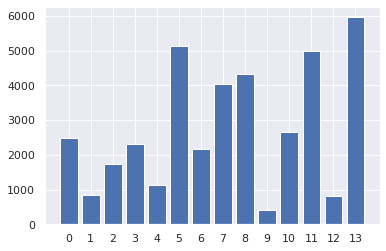

In [41]:
plt.bar([x[0] for x in hist_ori[:-1]], [x[1] for x in hist_ori[:-1]])
plt.show()

30-03-21 12:25:45 +++ Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
30-03-21 12:25:45 +++ Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


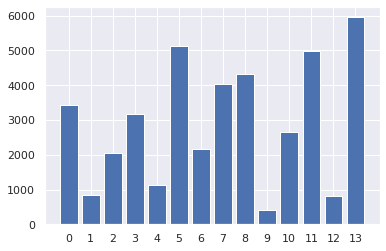

In [39]:
plt.bar([x[0] for x in hist_my], [x[1] for x in hist_my])
plt.show()

In [42]:
NORMAL = '14 1 0 0 1 1'

sample_submission = pd.read_csv(str(base_dir / 'sample_submission.csv'))
sample_submission = sample_submission.rename(columns={'PredictionString': 'PredicdtionString_'})
submission_det = pd.read_csv(str(base_dir / 'yolov5_results' / 'results02' / 'fold-1' / 'submission.csv'), index_col=0)
submission = pd.merge(sample_submission, submission_det)
submission.loc[submission[submission['PredictionString'].isnull()].index, 'PredictionString'] = NORMAL
submission

image_id PredicdtionString_  \
0     002a34c58c5b758217ed1f584ccbcfe9       14 1 0 0 1 1   
1     004f33259ee4aef671c2b95d54e4be68       14 1 0 0 1 1   
2     008bdde2af2462e86fd373a445d0f4cd       14 1 0 0 1 1   
3     009bc039326338823ca3aa84381f17f1       14 1 0 0 1 1   
4     00a2145de1886cb9eb88869c85d74080       14 1 0 0 1 1   
...                                ...                ...   
2995  ff91fb82429a27521bbec8569b041f02       14 1 0 0 1 1   
2996  ff9fcc4087ed5e941209aa3fa948e364       14 1 0 0 1 1   
2997  ffaa288c8abca300974f043b57d81521       14 1 0 0 1 1   
2998  ffc441e0c8b7153844047483a577e7c3       14 1 0 0 1 1   
2999  ffccf1709d0081d122a1d1f9edbefdf1       14 1 0 0 1 1   

                                       PredictionString  
0     0 0.04 1163 646 1438 903 3 0.233 828 1221 1896...  
1     0 0.803 1258 579 1528 898 3 0.014 1007 1490 19...  
2     0 0.812 1426 815 1736 1198 0 0.005 1088 1372 1...  
3     0 0.638 989 474 1215 735 0 0.006 778 474 1203 ...  
4     0 0.762 1118 710 1347 940 3 0.831 784 1279 184...  
...                                                 ...  
2995  0 0.783 1625 618 1877 917 1 0.009 851 1343 107...  
2996  0 0.791 1152 686 1422 1051 0 0.034 796 691 138...  
2997  1 0.011 1514 265 2028 537 1 0.01 1646 1455 233...  
2998  0 0.056 994 636 1230 900 3 0.173 736 1295 1518...  
2999  0 0.628 1373 870 1735 1281 0 0.012 1724 914 22...  

[3000 rows x 3 columns]

In [43]:
submission = pd.merge(submission, submission_2cls, how='left', on='image_id')
submission['class0'] = 1- submission['target']
submission.head()

image_id PredicdtionString_  \
0  002a34c58c5b758217ed1f584ccbcfe9       14 1 0 0 1 1   
1  004f33259ee4aef671c2b95d54e4be68       14 1 0 0 1 1   
2  008bdde2af2462e86fd373a445d0f4cd       14 1 0 0 1 1   
3  009bc039326338823ca3aa84381f17f1       14 1 0 0 1 1   
4  00a2145de1886cb9eb88869c85d74080       14 1 0 0 1 1   

                                    PredictionString    target    class0  
0  0 0.04 1163 646 1438 903 3 0.233 828 1221 1896...  0.013326  0.986674  
1  0 0.803 1258 579 1528 898 3 0.014 1007 1490 19...  0.037235  0.962765  
2  0 0.812 1426 815 1736 1198 0 0.005 1088 1372 1...  0.939700  0.060300  
3  0 0.638 989 474 1215 735 0 0.006 778 474 1203 ...  0.123799  0.876201  
4  0 0.762 1118 710 1347 940 3 0.831 784 1279 184...  0.654006  0.345994

In [44]:
low_threshold = 0.001
high_threshold = 0.87


c0, c1, c2 = 0, 0, 0
for i in range(len(submission)):
    p0 = submission.loc[i, "class0"]
    if p0 < low_threshold:

        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:

        submission.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
        c1 += 1
    else:

        submission.loc[i, "PredictionString"] = NORMAL
        c2 += 1
        
        
n_normal_after = len(submission.query("PredictionString == @NORMAL"))
print(f"Keep {c0} Add {c1} Replace {c2}")

Keep 0 Add 937 Replace 2063


In [45]:
submission = submission[['image_id', 'PredictionString']]
submission.to_csv(str(base_dir / 'submission.csv'), index=False)
submission

image_id  \
0     002a34c58c5b758217ed1f584ccbcfe9   
1     004f33259ee4aef671c2b95d54e4be68   
2     008bdde2af2462e86fd373a445d0f4cd   
3     009bc039326338823ca3aa84381f17f1   
4     00a2145de1886cb9eb88869c85d74080   
...                                ...   
2995  ff91fb82429a27521bbec8569b041f02   
2996  ff9fcc4087ed5e941209aa3fa948e364   
2997  ffaa288c8abca300974f043b57d81521   
2998  ffc441e0c8b7153844047483a577e7c3   
2999  ffccf1709d0081d122a1d1f9edbefdf1   

                                       PredictionString  
0                                          14 1 0 0 1 1  
1                                          14 1 0 0 1 1  
2     0 0.812 1426 815 1736 1198 0 0.005 1088 1372 1...  
3                                          14 1 0 0 1 1  
4     0 0.762 1118 710 1347 940 3 0.831 784 1279 184...  
...                                                 ...  
2995  0 0.783 1625 618 1877 917 1 0.009 851 1343 107...  
2996  0 0.791 1152 686 1422 1051 0 0.034 796 691 138...  
2997  1 0.011 1514 265 2028 537 1 0.01 1646 1455 233...  
2998  0 0.056 994 636 1230 900 3 0.173 736 1295 1518...  
2999  0 0.628 1373 870 1735 1281 0 0.012 1724 914 22...  

[3000 rows x 2 columns]